In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.3
pandas 0.25.3
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# https://storage.googleapis.com/tf-datasets/titanic/train.csv
# https://storage.googleapis.com/tf-datasets/titanic/eval.csv
# 定义训练集和测试集的路径
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"

# 使用pandas读取这两个数据集
# pandas的csv API可以读取解析csv文件
train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

# 使用pandas读取前五条数据
print(train_df.head())
print(eval_df.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [3]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

# head:默认取前五条数据
print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [4]:
# 利用pandas查看数据集中的一些统计量
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


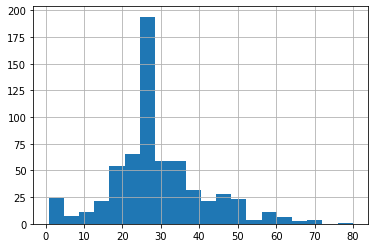

In [5]:
# .age:将age上的值取出来
# .hist:画直方图
# bins:将这些值分为多少份
train_df.age.hist(bins = 20)

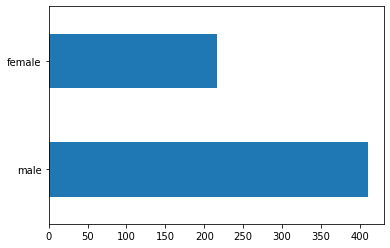

In [6]:
# value_counts:值的数目
# barh:横向图， barv:纵向图
train_df.sex.value_counts().plot(kind = 'barh')

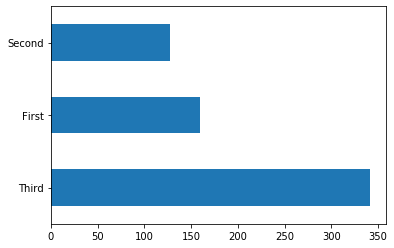

In [7]:
# class与保留字冲突
train_df['class'].value_counts().plot(kind = 'barh')

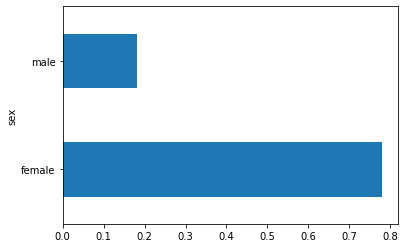

In [8]:
# 男性中有百分之多少获救，女性中有百分之多少获救
# concat:将数据集合并， axis:定义纬度
# groupby:分组
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind = 'barh')

In [9]:
# categorical_columns:离散特征 -> one-hot
# numeric_columns:连续特征 -> 直接用

categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class', 
                      'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []

# 对离散特征的处理
for categorical_column in categorical_columns:
    # 获得离散特征的所有可能的取值
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))

# 对连续特征的处理
for categorical_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            categorical_column, dtype = tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [16]:
# 构建dataset
# shuffle:是否混排
def make_dataset(data_df, label_df, epochs = 10, shuffle = True,
                batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset
    

In [17]:
train_dataset = make_dataset(train_df, y_train, batch_size = 5)

In [21]:
# import pprint
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: id=89, shape=(5,), dtype=string, numpy=array([b'male', b'male', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: id=81, shape=(5,), dtype=float64, numpy=array([28., 45., 28., 24., 32.])>, 'n_siblings_spouses': <tf.Tensor: id=87, shape=(5,), dtype=int32, numpy=array([0, 1, 0, 2, 0])>, 'parch': <tf.Tensor: id=88, shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 0])>, 'fare': <tf.Tensor: id=86, shape=(5,), dtype=float64, numpy=array([ 7.25 , 83.475,  7.225, 24.15 ,  8.05 ])>, 'class': <tf.Tensor: id=83, shape=(5,), dtype=string, numpy=array([b'Third', b'First', b'Third', b'Third', b'Third'], dtype=object)>, 'deck': <tf.Tensor: id=84, shape=(5,), dtype=string, numpy=array([b'unknown', b'C', b'unknown', b'unknown', b'E'], dtype=object)>, 'embark_town': <tf.Tensor: id=85, shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Cherbourg', b'Southampton',
       b'Southampton'], dtype=object)>, 'alone': <tf.Tensor: id=82, shape=(5,), dtype=

In [23]:
# keras.layers.DenseFeature:将feature_columns的规则应用到dataset每组数据上去
# feature_columns是一组对features进行变换的规则
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[28.]
 [59.]
 [14.]
 [50.]
 [57.]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base 

In [24]:
# keras.layers.DenseFeature:将feature_columns的规则应用到dataset每组数据上去
# feature_columns是一组对features进行变换的规则
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[ 36.       0.       1.       1.       0.       0.       1.       0.
    0.       0.       0.       0.       0.       0.       1.       0.
    0.       0.       7.8958   0.       1.       0.       0.       0.
    0.       0.       1.       0.       0.       0.       0.       0.
    1.       0.    ]
 [ 28.       1.       0.       1.       0.       0.       1.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    1.       0.      15.5      1.       0.       0.       0.       

In [27]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(2, activation = 'softmax'),
])
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = keras.optimizers.SGD(lr = 0.01),
             metrics = ['accuracy'])

In [29]:
# 1.model.fit
# 2.model -> estimator -> train
train_dataset = make_dataset(train_df, y_train, epochs  = 100)
eval_dataset = make_dataset(eval_df, y_eval, epochs = 1, shuffle = False)
history = model.fit(train_dataset,
                    validation_data = eval_dataset,
                   steps_per_epoch = 20,
                   validation_steps = 8,
                   epochs = 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train for 20 steps, validate for 8 steps
Epoch 1/100
20/20 [==============================] - 4s 207ms/step - loss: 1.9487 - accuracy: 0.5875 - val_loss: 0.7559 - val_accuracy: 0.5938
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.8404 - accuracy: 0.6750 - val_loss: 1.4403 - val_accuracy: 0.6250
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.7188 - accuracy: 0.6703 - val_loss: 0.6662 - val_accuracy: 0.6992
Epoch 4/100
20/20 [=======================

ValueError: Empty training data.

In [32]:
estimator = keras.estimator.model_to_estimator(model)
# 1. function
# 2. return  a.(features, labels) b. dataset ->(feature, label)
estimator.train(input_fn = lambda: make_dataset(
    train_df, y_train, epochs = 100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Dell\\AppData\\Local\\Temp\\tmpuz1r0gxa', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002C095E394A8>, '_task_type': 'worker', '_task_id': 0, '_global

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.